##importing libraries

In [ ]:
import requests
import numpy as np 
import pandas as pd
import json
from datetime import datetime
import plotly.express as px
import textblob

from textblob.classifiers import NaiveBayesClassifier
import nltk
import sklearn
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



##Adding the dataset

In [ ]:
dataset=pd.read_csv('january_comments.csv')
dataset.head()


,Unnamed: 0,Unnamed: 0.1,created_utc,author,subreddit,body,score,permalink,date,sentiment_polarity,sentiment_subjectivity,sentiment,preview,month
0,0,0,1577841828,Jouhou,China,"Honestly, the the Chinese climate and the high...",1,/r/China/comments/ehx3sw/an_unidentified_type_...,2020-01-01,0.139493,0.478382,positive,"Honestly, the the Chinese climate and the high...",1
1,1,1,1577851876,ImpracticalCats,VetTech,"This is interesting, I googled to try to figur...",1,/r/VetTech/comments/ei57ml/hello_anybody_here_...,2020-01-01,0.056818,0.586364,positive,"This is interesting, I googled to try to figur...",1
2,2,0,1577949412,MyrkyCat,Seattle,That symptom is not pathognomonic for RSV by a...,1,/r/Seattle/comments/ehnilr/what_the_heck_kind_...,2020-01-02,-0.017500,0.532500,negative,That symptom is not pathognomonic for RSV by a...,1
3,3,0,1577992294,murky_comparison,puppy101,"Immunity, even if the dog has experienced a na...",8,/r/puppy101/comments/ej2i1i/how_do_you_feel_ab...,2020-01-02,0.227778,0.370833,positive,"Immunity, even if the dog has experienced a na...",1
4,4,0,1578021955,foreignfishes,CatAdvice,If the two kittens lived together in the shelt...,1,/r/CatAdvice/comments/eivcf5/should_i_introduc...,2020-01-03,0.073125,0.589375,positive,If the two kittens lived together in the shelt...,1


In [ ]:
dataset.isnull().values.any()

False

In [ ]:
dataset.sort_values(by='score', ascending=True)

,Unnamed: 0,Unnamed: 0.1,created_utc,author,subreddit,body,score,permalink,date,sentiment_polarity,sentiment_subjectivity,sentiment,preview,month
11983,88983,370,1579820787,Canefan101,MLS,Mmm corona virus,0,/r/MLS/comments/esxhz7/espn_fc_javier_hernande...,2020-01-23,0.000000,0.000000,positive,Mmm corona virus,1
228,228,26,1579381304,autotldr,worldnews,"This is the best tl;dr I could make, [original...",0,/r/worldnews/comments/eqloi3/china_reports_new...,2020-01-18,0.250667,0.536219,positive,"This is the best tl;dr I could make, [original...",1
12361,89361,376,1579826233,jumpinjackieflash,houston,News says the Mexico case isn't corona virus.,0,/r/houston/comments/esy816/brazos_county_healt...,2020-01-24,0.000000,0.000000,positive,News says the Mexico case isn't corona virus.,1
12360,89360,375,1579829311,leerstand,PublicFreakout,You’re still under the impression that I said ...,0,/r/PublicFreakout/comments/et0l82/some_patient...,2020-01-24,0.039437,0.600275,positive,You’re still under the impression that I said ...,1
12359,89359,374,1579829544,GoodNooodle,dankmemes,Oh that. You should’ve said “*I* don’t get the...,0,/r/dankmemes/comments/esyfb6/god_go_commit_pla...,2020-01-24,0.000000,0.000000,positive,Oh that. You should’ve said “*I* don’t get the...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5554,5554,3,1580077107,EphemeralSun,TwoXChromosomes,"Yes, it's coronavirus.",256,/r/TwoXChromosomes/comments/eu99qg/after_10_ye...,2020-01-26,0.000000,0.000000,positive,"Yes, it's coronavirus.",1
5553,5553,2,1580069853,TronArclight,LivestreamFail,January 2020 is literally the worst month with...,306,/r/LivestreamFail/comments/eubizx/stephanie_al...,2020-01-26,-0.375000,0.781250,negative,January 2020 is literally the worst month with...,1
5552,5552,1,1580076546,Grayburger,mildlyinteresting,Anyone done the coronavirus joke yet?,352,/r/mildlyinteresting/comments/eucakq/this_defo...,2020-01-26,0.000000,0.000000,positive,Anyone done the coronavirus joke yet?,1
7551,7551,0,1580238385,yerich,worldnews,[From another article](https://www.dw.com/en/g...,589,/r/worldnews/comments/ev6zmb/japan_and_germany...,2020-01-28,-0.011905,0.495238,negative,[From another article](https://www.dw.com/en/g...,1


In [ ]:
dataset.groupby('score')['score'].count().sort_values(ascending=False)

score
1      15422
2       1251
3        897
4        454
5        398
       ...  
53         1
47         1
44         1
589        1
43         1
Name: score, Length: 87, dtype: int64

##In case of negative score in the dataset

In [ ]:
'''def remove_negatives(dataset):
     for i in range(-a,0): here at a put the value of the negative number whose score is to be changed
        dataset.replace(to_replace=i, value=1, inplace=True)
    return dataset
   dataset['score]=remove_negatives(dataset['score'])  
   '''

"def remove_negatives(dataset):\n     for i in range(-a,0): here at a put the value of the negative number whose score is to be changed\n        dataset.replace(to_replace=i, value=1, inplace=True)\n    return dataset\n   dataset['score]=remove_negatives(dataset['score'])  \n   "

##Data visualisations

In [ ]:
def groupbydate(dataset):
  newdataset=pd.DataFrame()
  dates=[]
  sums=[]
  dataset['date']=pd.to_datetime(dataset['date']).dt.date
  for date in dataset['date']:
    if date not in dates:
      dates.append(date)
      sums.append((dataset['date'] ==date).sum())
  newdataset['date']=dates
  newdataset['comments']=sums
  return newdataset
  
progression=groupbydate(dataset)
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=progression['date'], y=progression['comments']))

fig.update_layout(title='Number of comments about COVID-19 on Reddit per day',
                   xaxis_title='Date',
                   yaxis_title='Number of Comments')
fig.show()

print(progression['date'])



0     2020-01-01
1     2020-01-02
2     2020-01-03
3     2020-01-04
4     2020-01-07
5     2020-01-08
6     2020-01-09
7     2020-01-10
8     2020-01-11
9     2020-01-12
10    2020-01-13
11    2020-01-14
12    2020-01-15
13    2020-01-16
14    2020-01-17
15    2020-01-18
16    2020-01-19
17    2020-01-20
18    2020-01-21
19    2020-01-22
20    2020-01-23
21    2020-01-24
22    2020-01-25
23    2020-01-26
24    2020-01-27
25    2020-01-28
26    2020-01-29
27    2020-01-30
28    2020-01-31
Name: date, dtype: object


#january comments 

In [ ]:
fig = px.scatter(dataset, x="date", 
           y="sentiment_polarity",
           hover_data=["author", "permalink", "preview"], 
           color_discrete_sequence=["green", "red"],
           color="sentiment", 
           size="score", 
           size_max=50,
           labels={"sentiment_polarity": "Comment positivity", "date": "Date comment was posted"}, 
           title=f"Positivity of Reddit Comments about COVID-19 on January 2020")
fig.update_layout(
    autosize=False,
    width=800,
    height = 800,
    plot_bgcolor = 'white'
)
fig.show()



Output hidden; open in https://colab.research.google.com to view.

##CLeaning and Training

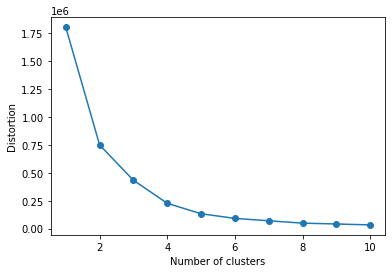

In [ ]:
df_km = pd.DataFrame(dataset['score'])
df_km['sentiment_polarity'] = dataset['sentiment_polarity']

# ELBOW METHOD

# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(df_km)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [ ]:
kclusters = 4

km = KMeans(n_clusters=kclusters, init='random',n_init=10, max_iter=300, 
    tol=1e-04, random_state=0).fit(df_km)

km_labels = km.labels_

# Let's change label numbers so they go from highest scores to lowest

replace_labels = {0:2, 1:0, 2:3, 3:1}

for i in range(len(km_labels)):
    km_labels[i] = replace_labels[km_labels[i]]
    
df_km['Cluster'] = km_labels
df_km.head()


,score,sentiment_polarity,Cluster
0,1,0.139493,2
1,1,0.056818,2
2,1,-0.017500,2
3,8,0.227778,2
4,1,0.073125,2


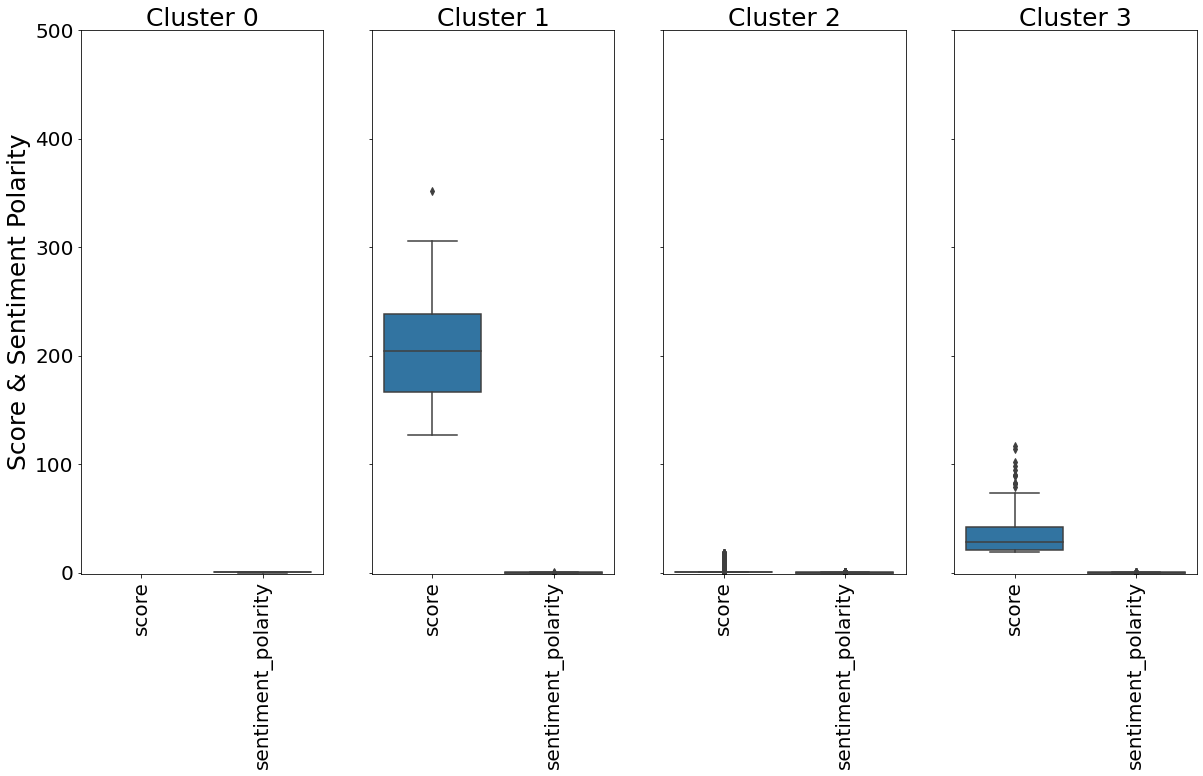

In [ ]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1, kclusters, figsize=(20, 10), sharey=True)

axes[0].set_ylabel('Score & Sentiment Polarity', fontsize=25)

for k in range(kclusters):
    # We are going to set same y axis limits
    axes[k].set_ylim(-1,500)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = df_km[df_km['Cluster'] == k].drop('Cluster',1), ax=axes[k])

plt.show()

In [ ]:
dataset['Cluster'] = df_km['Cluster']

df_cluster1 = dataset.loc[dataset['Cluster'] == 1]

#df_cluster1['date'] = df_cluster1['date'].apply(lambda x: float(x))

fig = px.scatter(df_cluster1, x="date",
           y="sentiment_polarity", 
           trendline = 'lowess',
           hover_data=["author", "permalink", "preview"], 
           color_discrete_sequence=["green", "red"], 
           color="sentiment", 
           size="score", 
           size_max=50,
           labels={"sentiment_polarity": "Comment positivity", "date": "Date comment was posted"}
           
          )
fig.update_layout(
    autosize=False,
    width=800,
    height = 800,
    plot_bgcolor = 'white'
)
fig.show()

TypeError: ignored

In [ ]:
data = pd.read_csv('./text_emotion.csv')

# Let's drop unnecessary columns from our dataset
data = data.drop('tweet_id', axis=1)
data = data.drop('author', axis=1)
data.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [ ]:
data['sentiment'].unique()


array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [ ]:
data = data.drop(data[data.sentiment == 'boredom'].index)
data = data.drop(data[data.sentiment == 'surprise'].index)
data = data.drop(data[data.sentiment == 'enthusiasm'].index)
data = data.drop(data[data.sentiment == 'empty'].index)
data = data.drop(data[data.sentiment == 'fun'].index)
data = data.drop(data[data.sentiment == 'relief'].index)
data = data.drop(data[data.sentiment == 'love'].index)
data = data.drop(data[data.sentiment == 'neutral'].index)

In [ ]:

data['sentiment'].replace(to_replace='hate', value='anger', inplace=True)
# Let's replace 'worry' for 'fear'
data['sentiment'].replace(to_replace='worry', value='fear', inplace=True)
# Let's see how many tweets we have for each sentiment
data.groupby('sentiment')['sentiment'].count().sort_values(ascending=False)

sentiment
fear         8459
happiness    5209
sadness      5165
anger        1433
Name: sentiment, dtype: int64

Synonym Replacement

In [ ]:
from nltk.corpus import wordnet
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
import random

def get_synonyms(word):
    """
    Get synonyms of a word
    """
    synonyms = set()
    
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)
def synonym_replacement(words, n):
    
    words = words.split()
    
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: #only replace up to n words
            break
        return sentence

# Random Insertion

def random_insertion(words, n):
    
    words = words.split()
    new_words = words.copy()
    
    for _ in range(n):
        add_word(new_words)
        
    sentence = ' '.join(new_words)
    return sentence

def add_word(new_words):
    
    synonyms = []
    counter = 0
    
    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
        
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words)-1)
    new_words.insert(random_idx, random_synonym)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Making all letters lowercase
data['content'] = data['content'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#Removing Punctuation, Symbols
data['content'] = data['content'].str.replace('[^\w\s]',' ')

#Removing urls, links
data['content'] = data['content'].str.replace('(www|http)\S+', ' ')

#Removing Stop Words using NLTK
from nltk.corpus import stopwords
stop = stopwords.words('english')
data['content'] = data['content'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [ ]:
nltk.download('wordnet')
p = stopwords.words('english')
data['content'] = data['content'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
#Lemmatisation
from textblob import Word
data['content'] = data['content'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

#Correcting Letter Repetitions
import re

def de_repeat(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

data['content'] = data['content'].apply(lambda x: " ".join(de_repeat(x) for x in x.split()))



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# Code to find the top 1000 rarest words appearing in the data
freq = pd.Series(' '.join(data['content']).split()).value_counts()[-1000:]

# Removing all those rarely appearing words from the data
freq = list(freq.index)
data['content'] = data['content'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
print(freq)
print(data['content'])


['xbb1qyx0e', 'looved', 'syamptoms', 'sliding', 'cleric20', 'pollybowles', 'draconator', 'artgrrl', 'ryanodonnell', 'kellichase', 'nettuts', 'icetv', 'hairdye', 'protest', 'christhesoul', 'penbleth', 'rejecting', 'mela', 'shakin', 'cleverindie', 'nemesis', 'tel', 'quashed', 'gourmetcook', 'workplace', 'wizardess', 'mbleah', 'microbe', 'wun', 'isle', 'neesabear', 'karuski', 'illy', 'realistic', 'pmsl', 'waynoo', 'snatch', 'abbreviation', 'individually', 'sweetiepie', 'paso', 'libbyoliver', 'yaa', 'charlej47', 'mlb', 'bucket', 'lauratoogood', 'nofearentertain', 'jordanbrown', 'paigex3', 'ungrateful', 'berkscub', 'qiuqiu', 'gedhead', 'runawayblue', 'letï', 'andreashale', 'tron', 'akte', 'feelinq', 'auflutterfly', 'everythin', 'jbobsessed', 'vosdjs', 'float', 'meadow', 'gwuhx', 'blaze', 'brandonjhon', 'chuckquartz', '7a10a', 'hawaiian', 'savagemike', 'robert', 'mrmaxroi', 'africanewtonxx', 'reminding', 'magically', 'invincible', 'kelli', 'tanapolis', 'osx', 'subponea', 'afrykah', 'karinber

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(data['content'])

word_index = tokenizer.word_index
print(len(word_index))
print(word_index)
sequences = tokenizer.texts_to_sequences(data['content'])
padded = pad_sequences(sequences, padding='post')
print(padded[0])
print(padded.shape)

In [ ]:
(pd.Series(nltk.ngrams(padded,2)).value_counts())[:10]

In [ ]:
#Encoding output labels
from sklearn import preprocessing
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(data.sentiment.values)

# Splitting into training and testing data in 90:10 ratio
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data.content.values, y, stratify=y, random_state=42, test_size=0.1, shuffle=True)

In [ ]:
print(lbl_enc.classes_)


In [ ]:
# Extracting TF-IDF parameters
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, analyzer='word',ngram_range=(1,3))
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.fit_transform(X_val)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(analyzer='word')
count_vect.fit(data['content'])
X_train_count =  count_vect.transform(X_train)
X_val_count =  count_vect.transform(X_val)

In [ ]:
from sklearn.metrics import accuracy_score
# Model 1: Multinomial Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred = nb.predict(X_val_tfidf)
print('naive bayes tfidf accuracy %s' % accuracy_score(y_pred, y_val))

# Model 2: Linear SVM
from sklearn.linear_model import SGDClassifier
lsvm = SGDClassifier(alpha=0.001, random_state=5, max_iter=15, tol=None)
lsvm.fit(X_train_tfidf, y_train)
y_pred = lsvm.predict(X_val_tfidf)
print('svm using tfidf accuracy %s' % accuracy_score(y_pred, y_val))

# Model 3: logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1, max_iter=21000)
logreg.fit(X_train_tfidf, y_train)
y_pred = logreg.predict(X_val_tfidf)
print('log reg tfidf accuracy %s' % accuracy_score(y_pred, y_val))

# Model 4: Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train_tfidf, y_train)
y_pred = rf.predict(X_val_tfidf)
print('random forest tfidf accuracy %s' % accuracy_score(y_pred, y_val))

naive bayes tfidf accuracy 0.4005920078934386
svm using tfidf accuracy 0.4040453872718303
log reg tfidf accuracy 0.3951652688702516
random forest tfidf accuracy 0.3695115934879132


In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_count, y_train)
y_pred = nb.predict(X_val_count)
print('naive bayes count vectors accuracy %s' % accuracy_score(y_pred, y_val))

# Model 2: Linear SVM
from sklearn.linear_model import SGDClassifier
lsvm = SGDClassifier(alpha=0.001, random_state=5, max_iter=15, tol=None)
lsvm.fit(X_train_count, y_train)
y_pred = lsvm.predict(X_val_count)
print('lsvm using count vectors accuracy %s' % accuracy_score(y_pred, y_val))

# Model 3: Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1, max_iter=21000)
logreg.fit(X_train_count, y_train)
y_pred = logreg.predict(X_val_count)
print('log reg count vectors accuracy %s' % accuracy_score(y_pred, y_val))

# Model 4: Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train_count, y_train)
y_pred = rf.predict(X_val_count)
print('random forest with count vectors accuracy %s' % accuracy_score(y_pred, y_val))

naive bayes count vectors accuracy 0.5204736063147508
lsvm using count vectors accuracy 0.5441539220522941
log reg count vectors accuracy 0.5303404045387272
random forest with count vectors accuracy 0.525407005426739


In [1]:
comments = dataset['body']

# Doing some preprocessing on these comments as done before
comments = comments.apply(lambda x: " ".join(x.lower() for x in x.split()))
comments = comments.str.replace('[^\w\s]',' ')
comments = comments.str.replace('(www|http)\S+', ' ')
from nltk.corpus import stopwords
stop = stopwords.words('english')
comments = comments.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
from textblob import Word
comments = comments.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
comments = comments.apply(lambda x: " ".join(de_repeat(x) for x in x.split()))
# Extracting Count Vectors feature from our Reddit comments
comment_count = count_vect.transform(comments)
comment_count=comment_count[:,0:1000]

#Predicting the emotion of the comment using our already trained logistic regression
comment_pred = lsvm.predict(comment_count)

NameError: ignored

In [ ]:
dataset['emotion'] = comment_pred.tolist()
dataset['emotion'].replace(to_replace=0, value='anger', inplace=True)
dataset['emotion'].replace(to_replace=1, value='fear', inplace=True)
dataset['emotion'].replace(to_replace=2, value='happiness', inplace=True)
dataset['emotion'].replace(to_replace=3, value='sadness', inplace=True)
dataset.groupby('emotion')['emotion'].count().sort_values(ascending=False)

In [ ]:
# Let's group comments by emotion
anger_comments = dataset.loc[dataset['emotion'] == 'anger']
fear_comments = dataset.loc[dataset['emotion'] == 'fear']
happiness_comments = dataset.loc[dataset['emotion'] == 'happiness']
sadness_comments = dataset.loc[dataset['emotion'] == 'sadness']

# Let's find out progressions of each emotion

anger_progression = groupbydate(anger_comments)
fear_progression = groupbydate(fear_comments)
happiness_progression = groupbydate(happiness_comments)
sadness_progression = groupbydate(sadness_comments)

In [ ]:
fig = go.Figure() 

fig.add_trace(go.Scatter(x=anger_progression["date"], y=anger_progression['comments'], 
                        name= 'Anger'))
fig.add_trace(go.Scatter(x=fear_progression["date"], y=fear_progression['comments'],
                        name = 'Fear'))
fig.add_trace(go.Scatter(x=happiness_progression["date"], y=happiness_progression['comments'],
                        name = 'Happiness'))
fig.add_trace(go.Scatter(x=sadness_progression["date"], y=sadness_progression['comments'],
                        name = 'Sadness'))

fig.update_layout(title='Emotions towards COVID-19 on Reddit',
                   xaxis_title='Date',
                   yaxis_title='Number of Comments')

fig.show()